In [42]:
"""
[V6]
Blend 6 Models:
* kibuna-nn-hs-1024-last-train (aka. 2stage-NN, LB: 0.01822)
* fork-of-2heads-looper-super-puper-markpeng-infer (LB: 0.1836)
* deepinsight-efficientnet-v7-b3-infer (LB: 0.01850)
* 503-203-tabnet-with-nonscored-features (LB: 0.01836)
* deepinsight_resnest_lightning_v2_infer (LB: 0.01854)

"""

kernel_mode = False

import os
import numpy as np
import pandas as pd
import time
import random
import math
import datetime
import glob

pd.set_option('display.max_rows', None)

from numba import njit
from scipy.optimize import minimize, fsolve

import optuna

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import gc
gc.enable()

rand_seed = 1120

search_mode = True
run_submit_script = False

method = "CV"
# method = "scipy"
# method = "optuna"
study_name = "moa_blend_team_v6"
# n_trials = 500
# n_trials = 3000
n_trials = 5000

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/gen-efficientnet-pretrained/tf_efficientnet_*.pth /root/.cache/torch/hub/checkpoints/
# !cp ../input/deepinsight-resnest-v1-resnest50/*.pth /root/.cache/torch/hub/checkpoints/
# !cp ../input/deepinsight-resnest-v2-resnest50-output/*.pth /root/.cache/torch/hub/checkpoints/
# !ls -la /root/.cache/torch/hub/checkpoints/

In [3]:
# !cp ../input/kaggle-moa-team/scripts/* .
# !ls -la

In [4]:
# !pip install --no-index --find-links /kaggle/input/pytorchtabnet/pytorch_tabnet-2.0.0-py3-none-any.whl pytorch-tabnet

In [5]:
dataset_folder = "../input/lish-moa" if kernel_mode else "/workspace/Kaggle/MoA/"

# Add your model inference script here
# Tuple Format: (script, oof_filename, output_filename, weight)
model_list = [
    ("2stageNN_with_ns_oldcv.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/2stageNN_with_ns_oldcv.py",
     "../../Github/kaggle_moa_team/oof/oof_2stageNN_ns_oldcv.npy",
     "submission_2stageNN_with_ns_oldcv_0.01822.csv",
     0.30923325055652684),
    
    ("script_simpleNN_oldcv.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/script_simpleNN_oldcv.py",
     "../../Github/kaggle_moa_team/oof/oof_script_simpleNN_oldcv.npy",
     "submission_script_simpleNN_oldcv_0.01836.csv",
     0.09831493504786226),
    
    ("fork-of-2heads-looper-super-puper-markpeng-infer.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/fork-of-2heads-looper-super-puper-markpeng-infer.py",
     "../../Github/kaggle_moa_team/oof/oof_fork-of-2heads-looper-super-puper-markpeng.npy",
     "submission_2heads-looper-super-puper_0.01836.csv",
     0.018966959973949222),
    
    ("deepinsight_efficientnet_lightning_v7_b3_infer.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/deepinsight_efficientnet_lightning_v7_b3_infer.py",
     "../../Github/kaggle_moa_team/oof/oof_deepinsight_efficientnet_lightning_v7_b3_0.01850.npy",
     "submission_effnet_v7_b3_0.01850.csv",
     0.19863369862866234),
    
    ("script_tabnet_ns_oldcv.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/script_tabnet_ns_oldcv.py",
     "../../Github/kaggle_moa_team/oof/oof_tabnet_ns_oldcv.npy",
     "submission_tabnet_ns_oldcv_0.01836.csv",
     0.0013224625996093413),
    
    ("deepinsight_resnest_lightning_v2_infer.py" if kernel_mode else "../../Github/kaggle_moa_team/scripts/deepinsight_resnest_lightning_v2_infer.py",
     "../../Github/kaggle_moa_team/oof/oof_deepinsight_ResNeSt_v2_resnest50_0.01854.npy",
     "submission_resnest_v2_0.01854.csv",
     0.3728865483320761),
]

model_path = "." if kernel_mode else dataset_folder

In [6]:
train_features = pd.read_csv(f"{dataset_folder}/train_features.csv",
                             engine='c')
train_labels = pd.read_csv(f'{dataset_folder}/train_targets_scored.csv',
                           engine='c')
train_classes = [c for c in train_labels.columns if c != "sig_id"]

non_control_group_rows = train_features["cp_type"] == "trt_cp"
non_control_group_train_labels = train_labels.loc[
    non_control_group_rows, :].copy().reset_index(drop=True)

submission = pd.read_csv(f'{dataset_folder}/sample_submission.csv')
submission.iloc[:, 1:] = 0

In [7]:
def mean_logloss(y_pred, y_true):
    logloss = (1 - y_true) * np.log(1 - y_pred +
                                    1e-15) + y_true * np.log(y_pred + 1e-15)
    return np.nanmean(-logloss)

## Bayesian Optimization and Sequential Least Squares Programming (SLSQP)
https://optuna.readthedocs.io/en/stable/reference/generated/optuna.samplers.TPESampler.html#optuna.samplers.TPESampler

https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html

In [8]:
def run_inference_scripts(submission, weights=None):
    for i, (script, oof_filename, output_filename, weight) in enumerate(model_list):
        print(f"Generating submission file from {script} ......")
        infer_start = time.time()
        !python {model_path}/{script}
        infer_elapsed = time.time() - infer_start
        print(f"Time spent on inference: {infer_elapsed/60:.2f} minutes.")

        model_submit = pd.read_csv(output_filename, engine='c')
        print(model_submit.head(5))
        print(model_submit.shape)
        if weights is None:
            print(f"Blending {script} with weight: {weight} ......")
            submission.iloc[:, 1:] += weight * model_submit.iloc[:, 1:]
        else:
            print(f"Blending {script} with weight: {weights[i]} ......")
            submission.iloc[:, 1:] += weights[i] * model_submit.iloc[:, 1:]

    return submission

In [9]:
total_start = time.time()

if not search_mode:
    submission = run_inference_scripts(submission)
elif search_mode and method == "CV":
    y_true = non_control_group_train_labels[train_classes].values

    all_oof = np.zeros(
        (len(model_list), non_control_group_train_labels.shape[0], 206))
    blend_oof = np.zeros((non_control_group_train_labels.shape[0], 206))
    print(all_oof.shape)
    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        all_oof[i, :, :] = oof
        blend_oof += oof * weight

        oof_loss = mean_logloss(oof, y_true)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")

    blend_oof_loss = mean_logloss(blend_oof, y_true)
    print(f"Blend OOF Validation Loss: {blend_oof_loss:.6f}\n")

elif search_mode and method == "optuna":
    print("[Optuna]")
    ## Search Best Blend Weights by Optuna ##
    model_oofs = []

    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        oof_loss = mean_logloss(
            oof, non_control_group_train_labels[train_classes].values)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")
        model_oofs.append(oof)

    def objective(trial):
        weights = []
        for i in range(len(model_list)):
            weights.append(trial.suggest_float(f"w{i}", 0, 1.0))

        blend = np.zeros(model_oofs[0].shape)
        for i in range(len(model_list)):
            blend += weights[i] * model_oofs[i]
        blend = np.clip(blend, 0, 1.0)

        loss = mean_logloss(
            blend, non_control_group_train_labels[train_classes].values)
        return loss

    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=0,
        interval_steps=1,
    )
    sampler = optuna.samplers.TPESampler(seed=rand_seed)
    study = optuna.create_study(direction="minimize",
                                pruner=pruner,
                                sampler=sampler,
                                study_name=study_name,
                                storage=f'sqlite:///{study_name}.db',
                                load_if_exists=True)

    study.optimize(objective,
                   n_trials=n_trials,
                   timeout=None,
                   gc_after_trial=True,
                   n_jobs=-1)

    trial = study.best_trial

    if run_submit_script:
        optimal_weights = []
        for i, (script, oof_filename, output_filename,
                _) in enumerate(model_list):
            optimal_weights.append(trial.params[f"w{i}"])
        submission = run_inference_scripts(submission, weights=optimal_weights)

    print("\n[Optuna]")
    print("Number of finished trials: {}".format(len(study.trials)))
    print("Best trial:")
    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

elif search_mode and method == "scipy":
    print("[Scipy SLSQP]")
    # Optimise Blending Weights with Bonus
    # https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0/notebook
    model_oofs = []
    y_true = non_control_group_train_labels[train_classes].values

    all_oof = np.zeros(
        (len(model_list), non_control_group_train_labels.shape[0], 206))
    print(all_oof.shape)
    for i, (script, oof_filename, output_filename,
            weight) in enumerate(model_list):
        print(f"Loading OOF from {oof_filename} ......")
        oof = np.load(f"{dataset_folder}/{oof_filename}")

        if oof.shape[0] == 23814:
            oof = oof[non_control_group_rows, :]

        all_oof[i, :, :] = oof

        oof_loss = mean_logloss(oof, y_true)
        print(f"OOF Validation Loss of {script}: {oof_loss:.6f}\n")
        model_oofs.append(oof)

    # Reference: https://www.kaggle.com/gogo827jz/optimise-blending-weights-with-bonus-0/notebook
    # CPMP's logloss from https://www.kaggle.com/c/lish-moa/discussion/183010
    def log_loss_numpy(y_pred, y_true):
        y_true_ravel = np.asarray(y_true).ravel()
        y_pred = np.asarray(y_pred).ravel()
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        loss = np.where(y_true_ravel == 1, -np.log(y_pred),
                        -np.log(1 - y_pred))
        return loss.mean()

    def func_numpy_metric(weights):
        oof_blend = np.tensordot(weights, all_oof, axes=((0), (0)))
        return log_loss_numpy(oof_blend, y_true)

    @njit
    def grad_func_jit(weights):
        oof_clip = np.minimum(1 - 1e-15, np.maximum(all_oof, 1e-15))
        gradients = np.zeros(all_oof.shape[0])
        for i in range(all_oof.shape[0]):
            a, b, c = y_true, oof_clip[i], np.zeros(
                (all_oof.shape[1], all_oof.shape[2]))
            for j in range(oof.shape[0]):
                if j != i:
                    c += weights[j] * oof_clip[j]
            gradients[i] = -np.mean(
                (-a * b + (b**2) * weights[i] + b * c) /
                ((b**2) *
                 (weights[i]**2) + 2 * b * c * weights[i] - b * weights[i] +
                 (c**2) - c))
        return gradients

    tol = 1e-10
    init_guess = [1 / all_oof.shape[0]] * all_oof.shape[0]
    bnds = [(0, 1) for _ in range(all_oof.shape[0])]
    cons = {
        'type': 'eq',
        'fun': lambda x: np.sum(x) - 1,
        'jac': lambda x: [1] * len(x)
    }

    print('Inital Blend OOF:', func_numpy_metric(init_guess))

    start_time = time.time()
    res_scipy = minimize(
        fun=func_numpy_metric,
        x0=init_guess,
        method='SLSQP',
        # jac=grad_func_jit,  # grad_func
        bounds=bnds,
        constraints=cons,
        tol=tol)
    print("\n[Scipy SLSQP]")
    print(
        f'[{str(datetime.timedelta(seconds = time.time() - start_time))[2:7]}] Optimised Blend OOF:',
        res_scipy.fun)
    print(f'Optimised Weights: {res_scipy.x}\n')

    if run_submit_script:
        submission = run_inference_scripts(submission, weights=res_scipy.x)

(6, 21948, 206)
Loading OOF from ../../Github/kaggle_moa_team/oof/oof_2stageNN_ns_oldcv.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/2stageNN_with_ns_oldcv.py: 0.015606

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_script_simpleNN_oldcv.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/script_simpleNN_oldcv.py: 0.015846

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_fork-of-2heads-looper-super-puper-markpeng.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/fork-of-2heads-looper-super-puper-markpeng-infer.py: 0.015887

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_deepinsight_efficientnet_lightning_v7_b3_0.01850.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/deepinsight_efficientnet_lightning_v7_b3_infer.py: 0.016016

Loading OOF from ../../Github/kaggle_moa_team/oof/oof_tabnet_ns_oldcv.npy ......
OOF Validation Loss of ../../Github/kaggle_moa_team/scripts/script_tabnet_

In [10]:
total_elapsed = time.time() - total_start
print(f"Total time spent: {total_elapsed/60:.2f} minutes.")

Total time spent: 0.02 minutes.


In [11]:
# [V6]
# [Optuna]
# Number of finished trials: 5000
# Best trial:
#   Value: 0.015173437622007157
#   Params: 
#     w0: 0.30923325055652684
#     w1: 0.09831493504786226
#     w2: 0.018966959973949222
#     w3: 0.19863369862866234
#     w4: 0.0013224625996093413
#     w5: 0.3728865483320761

# [Scipy SLSQP]
# [00:36] Optimised Blend OOF: 0.015172005464591968
# Optimised Weights: [3.20472642e-01 9.01191588e-02 1.78893358e-18 2.20448482e-01
#  3.27971157e-18 3.68959717e-01]

In [12]:
# [V5]
# Number of finished trials: 3000
# Best trial:
#   Value: 0.015344701181290615
#   Params: 
#     w0: 0.5141433844379889
#     w1: 0.11747776562133813
#     w2: 0.3668324643717302

# [00:14] Optimised Blend OOF: 0.015344695215068541
# Optimised Weights: [0.51922623 0.11292509 0.36784869]

In [13]:
# [V4]
# [Optuna]
# Number of finished trials: 3000
# Best trial:
#   Value: 0.015331901615194453
#   Params: 
#     w0: 0.4505928450756189
#     w1: 0.13010257032841785
#     w2: 0.06308933354044946
#     w3: 0.35639153615958885
#
# [Scipy]
# [00:23] Optimised Blend OOF: 0.015331777381591449
# Optimised Weights: [0.44090106 0.14508641 0.05945655 0.35455598]

In [14]:
# [V3]
# improving-mark-s-2-heads-model-infer
# Number of finished trials: 3000
# Best trial:
#   Value: 0.01515466145873492
#   Params: 
#     w0: 0.0002980690037490555
#     w1: 0.29771381784976886
#     w2: 0.1569191862042946
#     w3: 0.18156875605872544
#     w4: 0.36371774630338105

In [15]:
# [V3]
# fork-of-2heads-looper-super-puper-markpeng-infer
# Number of finished trials: 3000
# Best trial:
#   Value: 0.015170138066049686
#   Params: 
#     w0: 0.00019903389488299251
#     w1: 0.3853752127955825
#     w2: 0.015968332256452233
#     w3: 0.22945916769823432
#     w4: 0.3711290150522236

In [16]:
all_oof.shape, blend_oof.shape

((6, 21948, 206), (21948, 206))

## Correlation Analysis

In [44]:
class_counts = train_labels[train_classes].sum().to_frame(
    name="count").reset_index().rename(columns={"index": "class"})
class_counts = class_counts.sort_values(by="count",
                                        ascending=False).reset_index(drop=True)
class_counts

,class,count
0,nfkb_inhibitor,832
1,proteasome_inhibitor,726
2,cyclooxygenase_inhibitor,435
3,dopamine_receptor_antagonist,424
4,serotonin_receptor_antagonist,404
5,dna_inhibitor,402
6,glutamate_receptor_antagonist,367
7,adrenergic_receptor_antagonist,360
8,cdk_inhibitor,340
9,egfr_inhibitor,336


array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

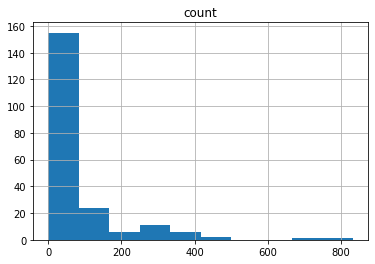

In [45]:
class_counts.hist()

In [27]:
# OOF scores per target
target_oof_losses = []
for i, target in enumerate(train_classes):
    print(target)
    # print(y_true[:, i])

    oof_loss = mean_logloss(blend_oof[:, i], y_true[:, i])
    target_oof_losses.append(oof_loss)
    print(f"Blend OOF Validation Loss of {target}: {oof_loss:.6f}\n")

5-alpha_reductase_inhibitor
Blend OOF Validation Loss of 5-alpha_reductase_inhibitor: 0.005494

11-beta-hsd1_inhibitor
Blend OOF Validation Loss of 11-beta-hsd1_inhibitor: 0.006239

acat_inhibitor
Blend OOF Validation Loss of acat_inhibitor: 0.008041

acetylcholine_receptor_agonist
Blend OOF Validation Loss of acetylcholine_receptor_agonist: 0.046313

acetylcholine_receptor_antagonist
Blend OOF Validation Loss of acetylcholine_receptor_antagonist: 0.067888

acetylcholinesterase_inhibitor
Blend OOF Validation Loss of acetylcholinesterase_inhibitor: 0.021482

adenosine_receptor_agonist
Blend OOF Validation Loss of adenosine_receptor_agonist: 0.015590

adenosine_receptor_antagonist
Blend OOF Validation Loss of adenosine_receptor_antagonist: 0.025162

adenylyl_cyclase_activator
Blend OOF Validation Loss of adenylyl_cyclase_activator: 0.001494

adrenergic_receptor_agonist
Blend OOF Validation Loss of adrenergic_receptor_agonist: 0.053420

adrenergic_receptor_antagonist
Blend OOF Validation 

Blend OOF Validation Loss of thymidylate_synthase_inhibitor: 0.009835

tlr_agonist
Blend OOF Validation Loss of tlr_agonist: 0.010185

tlr_antagonist
Blend OOF Validation Loss of tlr_antagonist: 0.002884

tnf_inhibitor
Blend OOF Validation Loss of tnf_inhibitor: 0.010922

topoisomerase_inhibitor
Blend OOF Validation Loss of topoisomerase_inhibitor: 0.011024

transient_receptor_potential_channel_antagonist
Blend OOF Validation Loss of transient_receptor_potential_channel_antagonist: 0.006334

tropomyosin_receptor_kinase_inhibitor
Blend OOF Validation Loss of tropomyosin_receptor_kinase_inhibitor: 0.002574

trpv_agonist
Blend OOF Validation Loss of trpv_agonist: 0.005578

trpv_antagonist
Blend OOF Validation Loss of trpv_antagonist: 0.014852

tubulin_inhibitor
Blend OOF Validation Loss of tubulin_inhibitor: 0.018377

tyrosine_kinase_inhibitor
Blend OOF Validation Loss of tyrosine_kinase_inhibitor: 0.016822

ubiquitin_specific_protease_inhibitor
Blend OOF Validation Loss of ubiquitin_spec

In [43]:
target_loss_df = pd.DataFrame(data={
    "target": train_classes,
    "oof_logloss": target_oof_losses
},
                              columns=["target", "oof_logloss"
                                       ]).sort_values(by="oof_logloss",
                                                      ascending=False).reset_index(drop=True)
target_loss_df

,target,oof_logloss
0,cyclooxygenase_inhibitor,0.088462
1,dopamine_receptor_antagonist,0.084394
2,serotonin_receptor_antagonist,0.083154
3,glutamate_receptor_antagonist,0.080933
4,adrenergic_receptor_antagonist,0.078773
5,dna_inhibitor,0.076873
6,acetylcholine_receptor_antagonist,0.067888
7,sodium_channel_inhibitor,0.062688
8,calcium_channel_blocker,0.062326
9,phosphodiesterase_inhibitor,0.059370


In [46]:
all_oof.shape

(6, 21948, 206)

In [51]:
all_mean_oof = np.zeros((all_oof.shape[0], all_oof.shape[2]))
for i in range(len(model_list)):
    model_oof = all_oof[i, :, :]
    all_mean_oof[i, :] = np.mean(model_oof, axis=0)

(206,)
(206,)
(206,)
(206,)
(206,)
(206,)


In [56]:
model_names = [m[2] for m in model_list]
corr_df = pd.DataFrame(data=all_mean_oof.T, columns=model_names)
corr_df

,submission_2stageNN_with_ns_oldcv_0.01822.csv,submission_script_simpleNN_oldcv_0.01836.csv,submission_2heads-looper-super-puper_0.01836.csv,submission_effnet_v7_b3_0.01850.csv,submission_tabnet_ns_oldcv_0.01836.csv,submission_resnest_v2_0.01854.csv
0,0.001408,0.001456,0.001388,0.001278,0.001448,0.001201
1,0.001442,0.001487,0.001484,0.001332,0.001572,0.001251
2,0.001763,0.001799,0.001580,0.001463,0.001731,0.001459
3,0.009405,0.009811,0.009421,0.010243,0.009605,0.008302
4,0.014549,0.015175,0.015345,0.015122,0.015078,0.013872
5,0.004000,0.004211,0.003805,0.003873,0.003785,0.003692
6,0.003065,0.003185,0.002802,0.003081,0.003172,0.002826
7,0.004970,0.005234,0.004822,0.004903,0.004532,0.004756
8,0.001247,0.001215,0.001234,0.001158,0.001269,0.001006
9,0.012507,0.011196,0.012348,0.014261,0.012197,0.011098


In [104]:
print(np.min(corr_df.corr(method='pearson')))
corr_df.corr(method='pearson')

submission_2stageNN_with_ns_oldcv_0.01822.csv       0.996905
submission_script_simpleNN_oldcv_0.01836.csv        0.994756
submission_2heads-looper-super-puper_0.01836.csv    0.997314
submission_effnet_v7_b3_0.01850.csv                 0.994756
submission_tabnet_ns_oldcv_0.01836.csv              0.997084
submission_resnest_v2_0.01854.csv                   0.996284
dtype: float64


,submission_2stageNN_with_ns_oldcv_0.01822.csv,submission_script_simpleNN_oldcv_0.01836.csv,submission_2heads-looper-super-puper_0.01836.csv,submission_effnet_v7_b3_0.01850.csv,submission_tabnet_ns_oldcv_0.01836.csv,submission_resnest_v2_0.01854.csv
submission_2stageNN_with_ns_oldcv_0.01822.csv,1.000000,0.996905,0.998362,0.998061,0.998616,0.998919
submission_script_simpleNN_oldcv_0.01836.csv,0.996905,1.000000,0.997314,0.994756,0.997370,0.997061
submission_2heads-looper-super-puper_0.01836.csv,0.998362,0.997314,1.000000,0.997505,0.998470,0.997778
submission_effnet_v7_b3_0.01850.csv,0.998061,0.994756,0.997505,1.000000,0.997084,0.996284
submission_tabnet_ns_oldcv_0.01836.csv,0.998616,0.997370,0.998470,0.997084,1.000000,0.998048
submission_resnest_v2_0.01854.csv,0.998919,0.997061,0.997778,0.996284,0.998048,1.000000


Text(0.5, 1.0, 'Pearson Correlation Heatmap of Blend OOF Predictions')

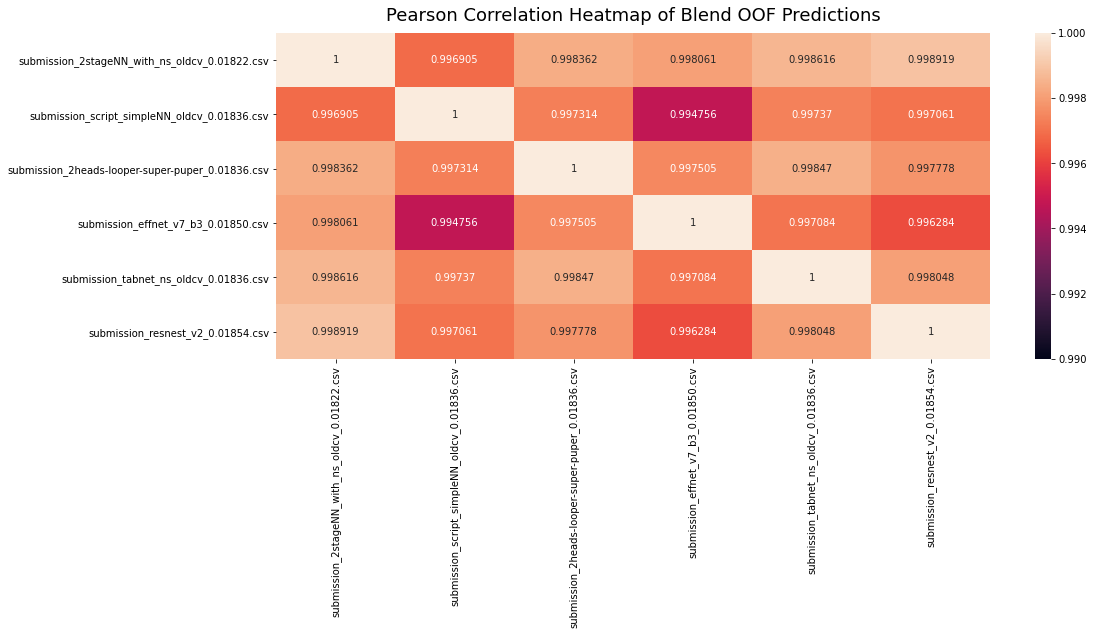

In [105]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df.corr(method='pearson'),
                      vmin=0.99,
                      vmax=1,
                      fmt='.6g',
                      annot=True)
                      # center=0.7)
                      # annot=True)
                      # cmap='jet')
                      # cmap='BrBG')
heatmap.set_title('Pearson Correlation Heatmap of Blend OOF Predictions',
                  fontdict={'fontsize': 18},
                  pad=12)

In [106]:
print(np.min(corr_df.corr(method='spearman')))
corr_df.corr(method='spearman')

submission_2stageNN_with_ns_oldcv_0.01822.csv       0.993587
submission_script_simpleNN_oldcv_0.01836.csv        0.990825
submission_2heads-looper-super-puper_0.01836.csv    0.990825
submission_effnet_v7_b3_0.01850.csv                 0.991849
submission_tabnet_ns_oldcv_0.01836.csv              0.991849
submission_resnest_v2_0.01854.csv                   0.993867
dtype: float64


,submission_2stageNN_with_ns_oldcv_0.01822.csv,submission_script_simpleNN_oldcv_0.01836.csv,submission_2heads-looper-super-puper_0.01836.csv,submission_effnet_v7_b3_0.01850.csv,submission_tabnet_ns_oldcv_0.01836.csv,submission_resnest_v2_0.01854.csv
submission_2stageNN_with_ns_oldcv_0.01822.csv,1.000000,0.995705,0.995257,0.993587,0.995495,0.995909
submission_script_simpleNN_oldcv_0.01836.csv,0.995705,1.000000,0.990825,0.992211,0.993158,0.995094
submission_2heads-looper-super-puper_0.01836.csv,0.995257,0.990825,1.000000,0.993072,0.994088,0.993867
submission_effnet_v7_b3_0.01850.csv,0.993587,0.992211,0.993072,1.000000,0.991849,0.994926
submission_tabnet_ns_oldcv_0.01836.csv,0.995495,0.993158,0.994088,0.991849,1.000000,0.994615
submission_resnest_v2_0.01854.csv,0.995909,0.995094,0.993867,0.994926,0.994615,1.000000


Text(0.5, 1.0, 'Spearman Correlation Heatmap of Blend OOF Predictions')

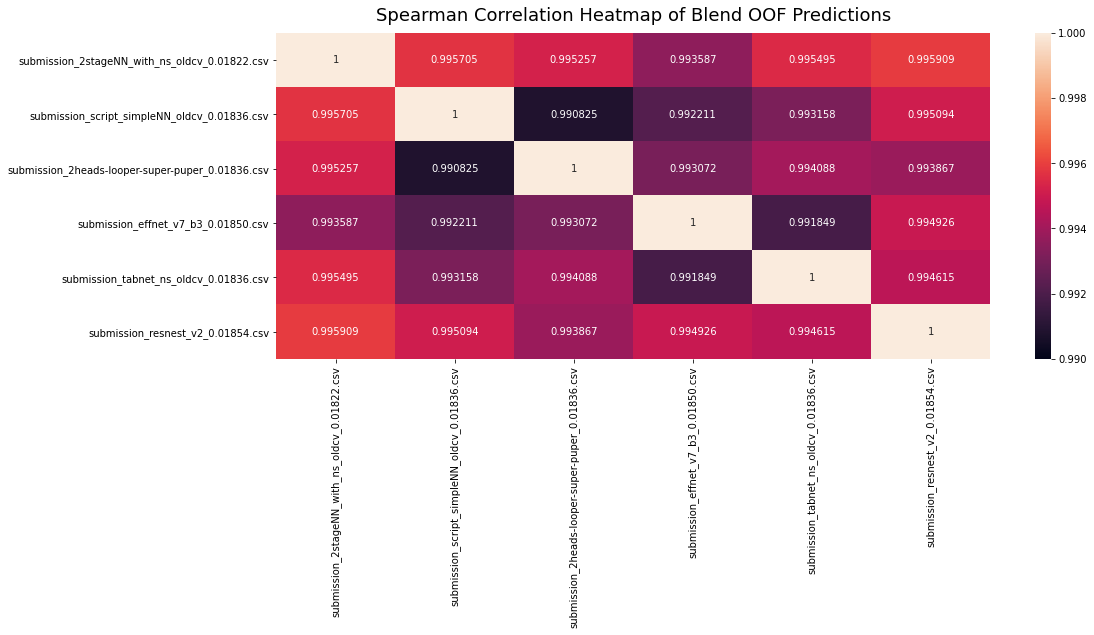

In [107]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df.corr(method='spearman'),
                      vmin=0.99,
                      vmax=1,
                      fmt='.6g',
                      annot=True)
                      # center=0.7)
                      # annot=True)
                      # cmap='jet')
                      # cmap='BrBG')
heatmap.set_title('Spearman Correlation Heatmap of Blend OOF Predictions',
                  fontdict={'fontsize': 18},
                  pad=12)

In [110]:
print(np.min(corr_df.corr(method='kendall')))
corr_df.corr(method='kendall')

submission_2stageNN_with_ns_oldcv_0.01822.csv       0.935875
submission_script_simpleNN_oldcv_0.01836.csv        0.924509
submission_2heads-looper-super-puper_0.01836.csv    0.924509
submission_effnet_v7_b3_0.01850.csv                 0.925172
submission_tabnet_ns_oldcv_0.01836.csv              0.926971
submission_resnest_v2_0.01854.csv                   0.939569
dtype: float64


,submission_2stageNN_with_ns_oldcv_0.01822.csv,submission_script_simpleNN_oldcv_0.01836.csv,submission_2heads-looper-super-puper_0.01836.csv,submission_effnet_v7_b3_0.01850.csv,submission_tabnet_ns_oldcv_0.01836.csv,submission_resnest_v2_0.01854.csv
submission_2stageNN_with_ns_oldcv_0.01822.csv,1.000000,0.949515,0.945821,0.935875,0.945252,0.949420
submission_script_simpleNN_oldcv_0.01836.csv,0.949515,1.000000,0.924509,0.925172,0.931328,0.940990
submission_2heads-looper-super-puper_0.01836.csv,0.945821,0.924509,1.000000,0.936254,0.938054,0.939569
submission_effnet_v7_b3_0.01850.csv,0.935875,0.925172,0.936254,1.000000,0.926971,0.941937
submission_tabnet_ns_oldcv_0.01836.csv,0.945252,0.931328,0.938054,0.926971,1.000000,0.940706
submission_resnest_v2_0.01854.csv,0.949420,0.940990,0.939569,0.941937,0.940706,1.000000


Text(0.5, 1.0, 'Kendall Correlation Heatmap of Blend OOF Predictions')

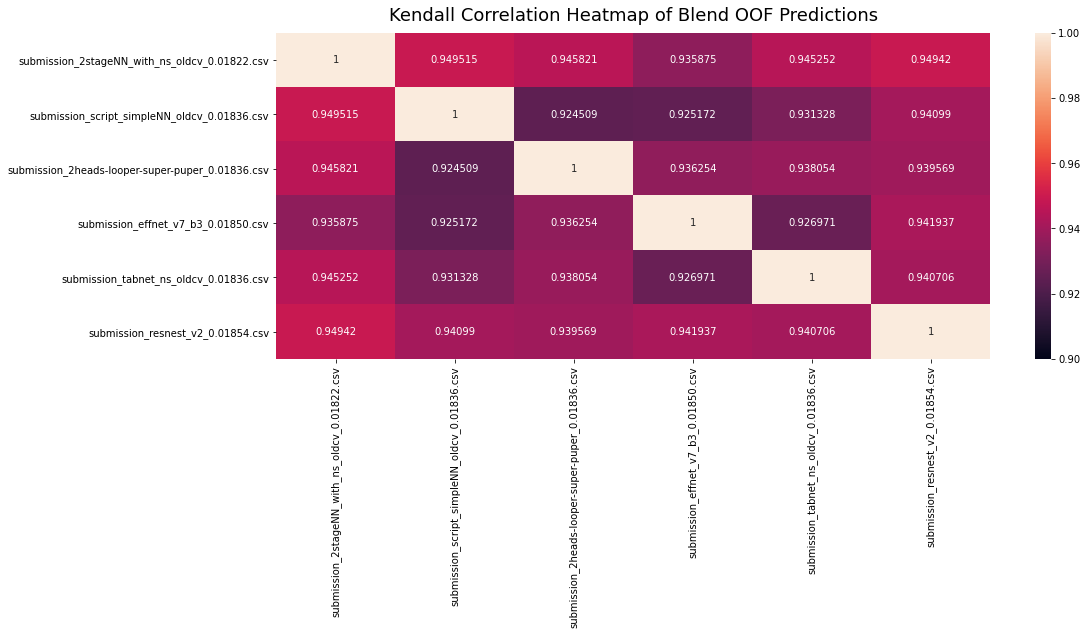

In [113]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(corr_df.corr(method='kendall'),
                      vmin=0.9,
                      vmax=1,
                      fmt='.6g',
                      annot=True)
                      # center=0.7)
                      # annot=True)
                      # cmap='jet')
                      # cmap='BrBG')
heatmap.set_title('Kendall Correlation Heatmap of Blend OOF Predictions',
                  fontdict={'fontsize': 18},
                  pad=12)

In [20]:
if run_submit_script:
    print(submission.shape)
    print(submission)
    submission.to_csv('submission.csv', index=False)

## EOF

In [21]:
if kernel_mode:
    !rm ./*.py
    !ls -la